# Lungs Segmentation
The segmentation of lungs may, possibly, proceed directly in 3D as follows:
1. Run binarization of the CT image using a threshold of -320 HU – every voxel
with HU lower than this threshold should receive label 1 (air label) and the
remaining voxels should receive label 0
2. Use body mask to select only air regions within body
3. Design a sequence of morphological (and other appropriate) operations to fill
the holes in the interior of lungs and to remove ‘air’ clusters which do not
correspond to lungs (e.g. gas in bowels) – at the end one should be left with
clusters which correspond only to airways
4. Use watershed from markers (scikit-image -> segmentation -> watershed) to
extract the left and the right lung from the segmentation being the result of step
(3) above. Before using watershed design a procedure for defining the three
markers (marker of left lung, marker of right lung, marker of background).
5. To compare segmentation results with reference segmentations available at
Lab One Drive use Dice coefficient and Hausdorff distance (find the definitions of
these   quantities)   as   implemented   in   surface-distance   [package](https://github.com/google-deepmind/surface-distance).
The project results (Dice coefficients and Hausdorff distance) should be
reported   for   the   three   tasks:   body   mask   segmentation,   left   lung
segmentation, right lung segmentation.


## Imports

In [586]:
import numpy as np
import nibabel as nib
import cv2
from skimage import morphology, measure
from skimage.segmentation import watershed
from skimage import filters
from scipy import ndimage
import matplotlib.pyplot as plt
# from pycimg import CImg


## Load / save .nii files and Visualization

In [587]:
def load_nii_gz_file(file_path: str) -> tuple:
    nii_img = nib.load(file_path)
    nii_data = nii_img.get_fdata()
    return nii_data, nii_img.affine

def save_to_nii(segmented_data: np.ndarray, affine: np.ndarray, output_path: str) -> None:
    segmented_nii = nib.Nifti1Image(segmented_data.astype(np.uint8), affine)
    nib.save(segmented_nii, output_path)
    
def view_nii_data(nii_data: np.ndarray) -> None:
    for i in range(nii_data.shape[2]):
        cv2.imshow('slice', nii_data[:, :, i])
        cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def visualize_photos(original: np.ndarray, segmented: np.ndarray, reference: np.ndarray, *slices: int) -> None:
    num_slices = len(slices)
    plt.figure(figsize=(15, 5 * num_slices))  # Adjust figure size based on the number of slices

    for i, slice_num in enumerate(slices):
        # Original slice
        plt.subplot(num_slices, 3, 3 * i + 1)
        plt.title(f"Original Slice {slice_num}")
        plt.imshow(original[:, :, slice_num], cmap="gray")
        
        # Segmented slice
        plt.subplot(num_slices, 3, 3 * i + 2)
        plt.title(f"Segmented Slice {slice_num}")
        plt.imshow(segmented[:, :, slice_num], cmap="gray")
        
        # Reference slice
        plt.subplot(num_slices, 3, 3 * i + 3)
        plt.title(f"Reference Slice {slice_num}")
        plt.imshow(reference[:, :, slice_num], cmap="gray")

    plt.tight_layout() 
    plt.show()

## 1. Binarization

In [588]:
def binarize_images(image: np.ndarray, threshold: float = -320, use_otsu: bool = False) -> np.ndarray:
    threshold = filters.threshold_otsu(image) if use_otsu else threshold
    image = np.where(image < threshold, 1, 0)
    return image.astype(np.uint8)

## 2. Bodymask / Floodfill

In [589]:
def apply_body_mask(base_img: np.ndarray, body_mask: np.ndarray) -> np.ndarray:
    base_img = base_img * body_mask
    return base_img.astype(np.uint8)

In [590]:
def flood_fill_3d(imgs: np.ndarray) -> np.ndarray:
        return np.array([flood_fill_2d(img_slice) for img_slice in imgs])

def flood_fill_2d(slice: np.ndarray) -> np.ndarray:
    if len(slice.shape) == 3 and slice.shape[2] == 3: # check greyscale
        slice = cv2.cvtColor(slice, cv2.COLOR_BGR2GRAY)
    slice = slice.astype(np.uint8)
    
    # copy for flood filling
    background_filled = slice.copy()
    cv2.floodFill(background_filled, None, (0, 0), 0) # start at (0,0), fill background with 0

    return background_filled

## 3. Sequence of morphological operations

In [591]:
def transform_3d(imgs: np.ndarray, min_lung_size: int = 1000) -> np.ndarray:
    return np.array([transform_2d(img_slice, min_lung_size) for img_slice in imgs])


def transform_2d(img: np.ndarray, min_lung_size: int = 1000) -> np.ndarray:
    if len(img.shape) == 3 and img.shape[2] == 3: # check greyscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    kernel = np.ones((5, 5), np.uint8)
    closed_image = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    opened_image = cv2.morphologyEx(closed_image, cv2.MORPH_OPEN, kernel)

    img_filled = ndimage.binary_fill_holes(opened_image)
    components, num_labels = ndimage.label(img_filled)
    lung_candidates = morphology.remove_small_objects(components, min_size=min_lung_size)

    lungs_mask = lung_candidates > 0

    return lungs_mask.astype(np.uint8)

## 4. Watershed 

In [592]:
def watershed_3d(imgs: np.ndarray, min_lung_size: int = 1000) -> np.ndarray:
    return np.array([watershed_2d(img_slice, min_lung_size) for img_slice in imgs])

def watershed_2d(img: np.ndarray, min_lung_size: int = 1000) -> np.ndarray:
    distance_map = ndimage.distance_transform_edt(img)
    local_max = morphology.local_maxima(distance_map, indices=False, footprint=np.ones((3, 3)))
    markers = measure.label(local_max)
    labels = watershed(-distance_map, markers, mask=img)
    return labels.astype(np.uint8)


## 5. Evaluation

In [593]:
from scipy.spatial.distance import directed_hausdorff
def calculate_dice_coefficient(pred: np.ndarray, truth: np.ndarray) -> float:
    intersection = np.sum(pred * truth)
    total = np.sum(pred) + np.sum(truth)
    if total == 0:
        return 1.0 if np.sum(pred) == 0 and np.sum(truth) == 0 else 0.0
    return (2 * intersection) / total

def calculate_hausdorff_distance(pred: np.ndarray, truth: np.ndarray) -> float:

    pred_points = np.argwhere(pred == 1)
    truth_points = np.argwhere(truth == 1)
    
    if len(pred_points) == 0 or len(truth_points) == 0:
        return np.inf

    d_pred_truth = directed_hausdorff(pred_points, truth_points)[0]
    d_truth_pred = directed_hausdorff(truth_points, pred_points)[0]
    
    return max(d_pred_truth, d_truth_pred)

def calculate_score(data: np.ndarray, reference_data: np.ndarray) -> float:
    data = data.astype(bool)
    reference_data = reference_data.astype(bool)
    
    dice_coefficient = calculate_dice_coefficient(data, reference_data)
    hausdorff_distance = calculate_hausdorff_distance(data, reference_data)
    
    return dice_coefficient, hausdorff_distance

## Main

In [594]:
def main(img_path: str,reference_img_path: str, body_mask_path: str, output_path: str, ) -> None:
    # load images
    img, affine = load_nii_gz_file(img_path)
    body_masks, _ = load_nii_gz_file(body_mask_path)
    reference_img, _ = load_nii_gz_file(reference_img_path)

    # transform
    imgs_transform = binarize_images(img, use_otsu=False)
    # imgs_transform = apply_body_mask(imgs_transform, body_masks)
    imgs_transform = transform_3d(imgs_transform)
    imgs_transform = flood_fill_3d(imgs_transform)
    # imgs_transform = watershed_3d(imgs_transform)
    visualize_photos(img, imgs_transform, reference_img, 50, 70, 100, 120)
    print("Dice_coefficient, Hausdorff_distance", calculate_score(imgs_transform, reference_img))

## Run code

/tmp/ipykernel_1477/172316842.py:15: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  lung_candidates = morphology.remove_small_objects(components, min_size=min_lung_size)


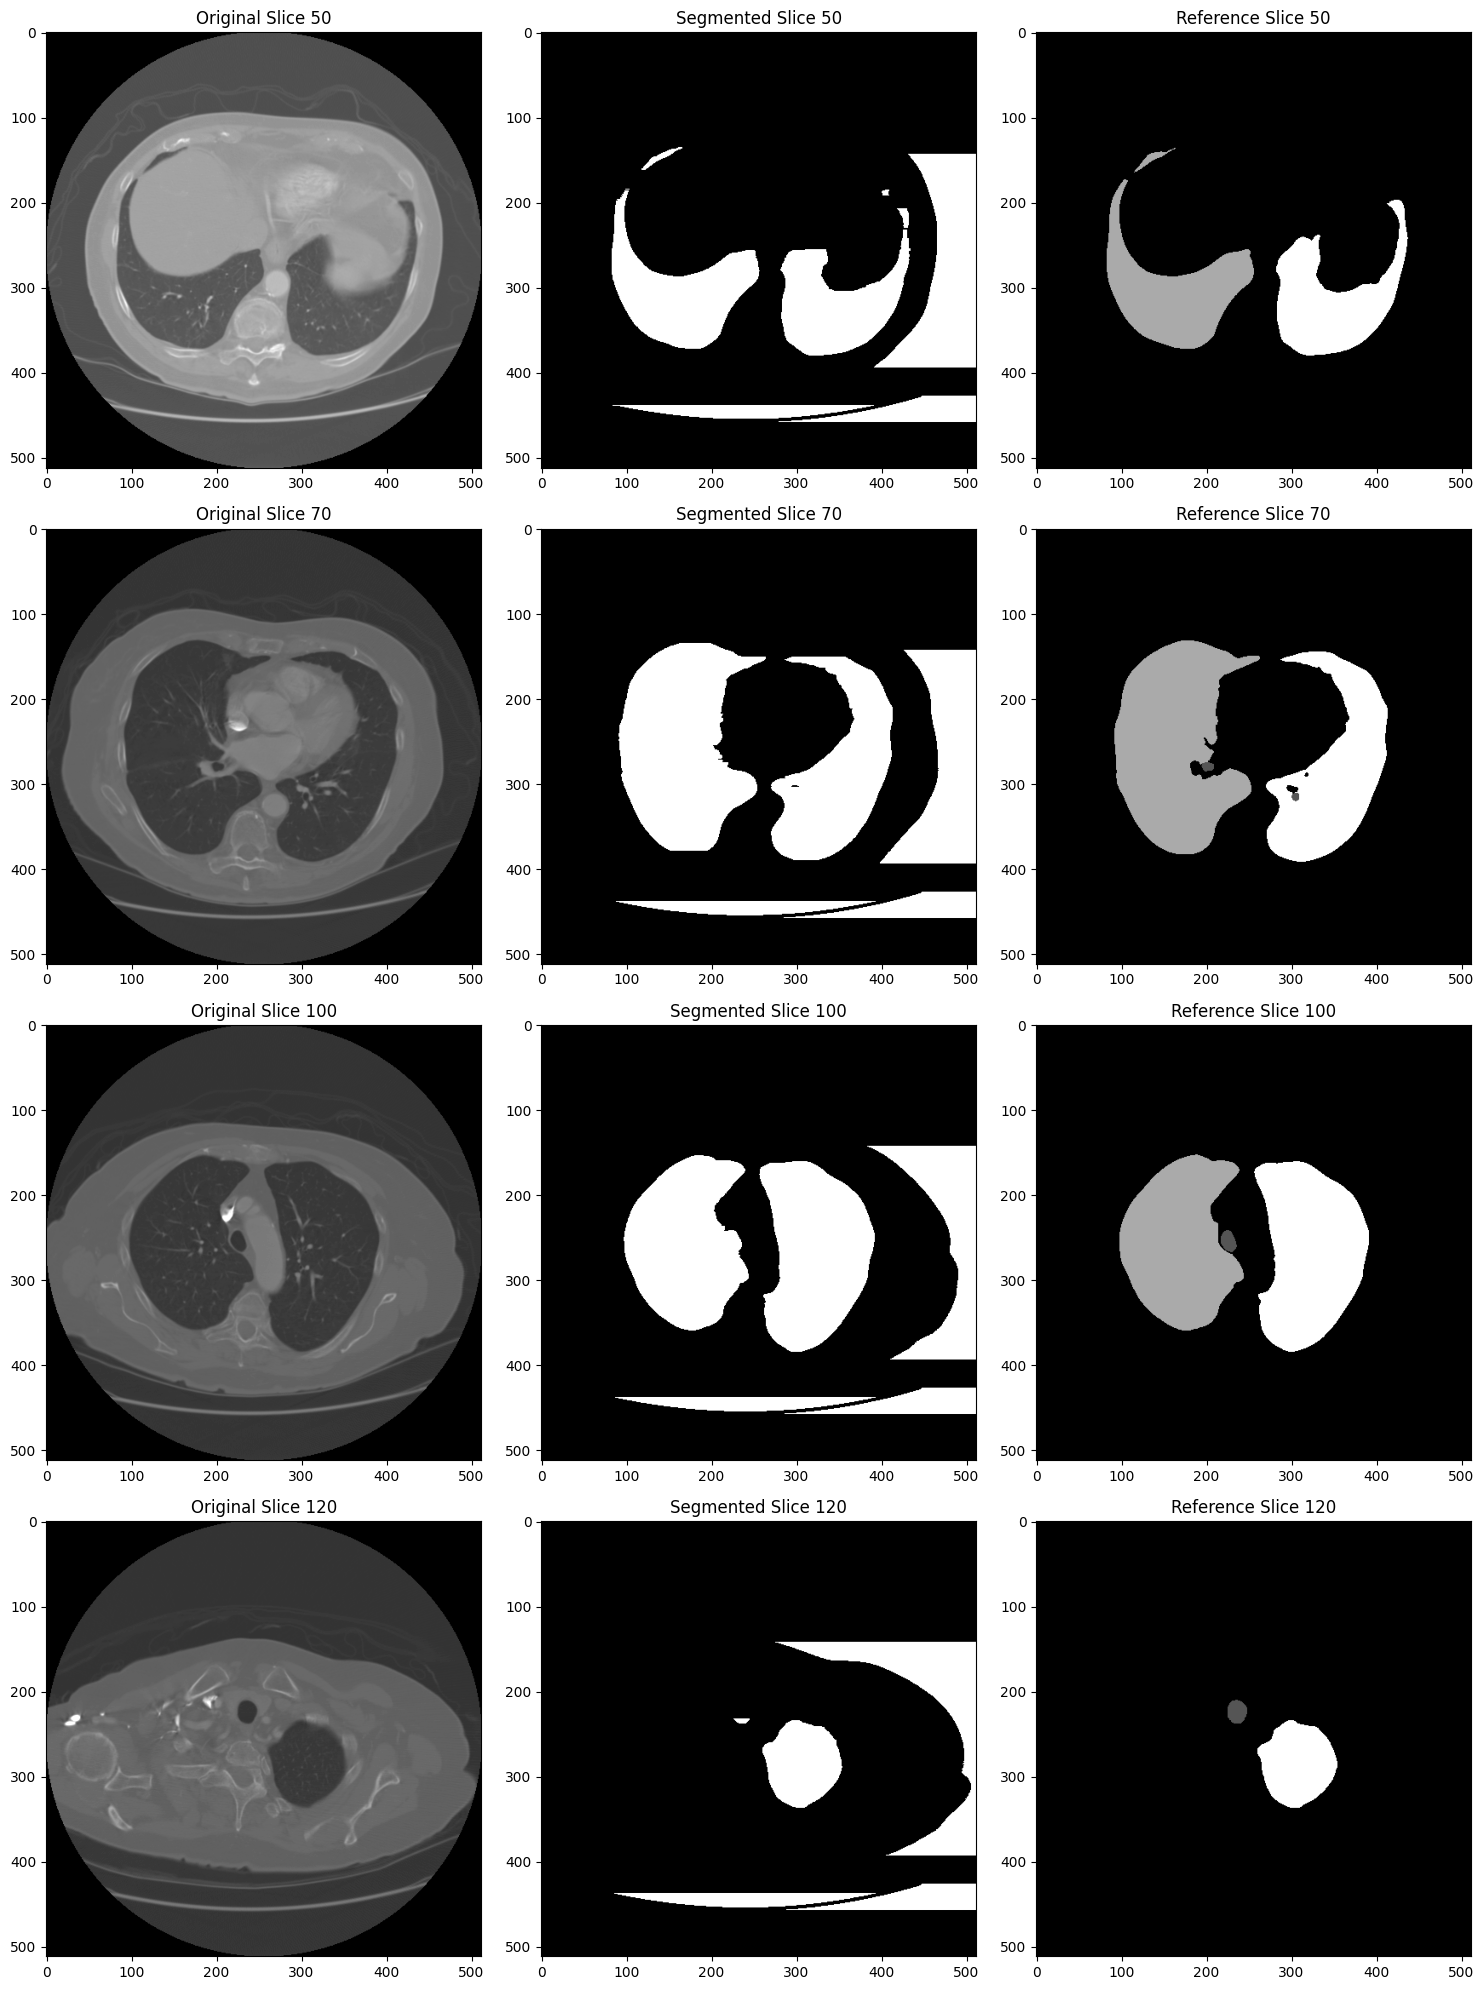

Dice_coefficient, Hausdorff_distance (np.float64(0.6627331617465265), 175.87779848519824)


In [595]:
main('Images/IMG_0001.nii.gz','ReferenceSegmentations/LUNGS_IMG_0001.nii.gz', 'BodyMasks/BODYMASK_IMG_0001.nii.gz', 'output.nii.gz')
